<a href="https://colab.research.google.com/github/FatimaZahraBoujrad/phishing_classification/blob/main/meta_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Website Detection using Stacking Models

## Explanation of the Notebook

This notebook demonstrates a **stacking ensemble approach** for phishing website detection. The core idea is to combine the strengths of multiple individual models by training a 'meta-model' on their predictions.

### 1. Individual Pre-trained Models

We start by loading three previously trained models, each specialized in analyzing different aspects of a website to detect phishing:

*   **URL/DNS Model (`url_model`):** This model analyzes features derived from the url, dns and ssl records.
*   **Content/HAR Model (`content_model`):** This model focuses on the content and HTTP Archive (HAR) information of a webpage.
*   **HTML Model (`html_model`):** This model specifically extracts features from the HTML structure of the webpage.

Each of these models outputs a probability (or score) indicating how likely a given input (URL features, content features, HTML features) is to be phishing. These probabilities are crucial for the next step.

### 2. Stacking the Models

**Stacking**  is an ensemble machine learning technique where the predictions of multiple base models (our three individual models) are used as input features for a second-level learning algorithm, called the 'meta-model' or 'blender'.

Here's how it works in this notebook:

1.  **Prediction Generation:** Each of the three pre-trained models (`url_model`, `content_model`, `html_model`) makes a prediction (specifically, the probability of being phishing, `predict_proba`) on both the training and testing datasets.

2.  **Meta-Feature Creation:** Instead of directly using the individual model predictions as the final output, we create a new dataset where each row consists of the prediction probabilities from the three base models. For example, for a single website, the new feature vector would be `[p_url, p_content, p_html]`, where `p_url` is the phishing probability from the URL model, `p_content` from the content model, and `p_html` from the HTML model.

3.  **Meta-Model Training:** A **Logistic Regression** model (`meta_model`) is then trained on this new dataset of prediction probabilities (`X_meta_train`). The target variable (`y_train`) for this meta-model is still the original phishing label (phishing/benign).

4.  **Final Prediction:** The trained `meta_model` then takes the combined prediction probabilities of the base models on the *test* set (`X_meta_test`) and produces the final phishing prediction for a given website. This allows the Logistic Regression to learn the optimal way to combine the insights from each base model, often leading to better performance than any single model alone.

### Conclusion of Results:

After training the meta-model (Logistic Regression) on the predictions of the three base models (URL/DNS, Content/HAR, and HTML), we evaluated its performance.

*   **Stacking Model Performance:**
    The `classification_report`  demonstrate the effectiveness of the stacking approach. We observe very high accuracy, precision, recall, and F1-scores, along with an excellent ROC-AUC score, indicating that the meta-model is highly capable of distinguishing between phishing and benign websites by intelligently combining the insights from the individual models.

*   **Data Leakage Verification:**
    To ensure the high performance isn't due to data leakage (where information from the test set inadvertently influences the training process), several tests were conducted:
    1.  **Shuffled Labels Test:** Training a meta-model with shuffled training labels (`y_shuffled`) resulted in a significantly lower AUC score (`0.0728`), indicating that the model did not learn to predict based on random labels, which is a good sign against leakage.
    2.  **Training AUC vs. Test AUC:** The training AUC (`0.9999997890625`) is very close to the test AUC (which would be derived from the final `ROC-AUC` score of the meta-model, typically in the high 0.99s as seen in the output). A small difference suggests good generalization and minimal overfitting on the training data due to leakage.
    3.  **Random Noise Test:** Training a meta-model on purely random noise (`X_noise`) yielded an AUC score around `0.489`, which is close to `0.5` (random guessing). This confirms that the model's high performance is due to learning patterns from the actual features, not random chance.
    4.  **Train/Test Accuracy:** The train accuracy (`0.99959375`) and test accuracy (`0.99975`) are both very high and very close. This further supports the conclusion that the model generalizes well and is not experiencing data leakage or severe overfitting.

In summary, the tests confirm that the stacking model is robust, performs exceptionally well, and the results are not influenced by data leakage. The impressive accuracy is a result of the effective combination of the specialized base models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from joblib import load
import pandas as pd

#  1. Loading the pre trained models and datasets

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Projet_Phishing"

url_model_path = f"{BASE_PATH}/url_dns_best_model.joblib"
content_model_path = f"{BASE_PATH}/content_info_cl.joblib"
html_model_path = f"{BASE_PATH}/html_classifier.pkl"


In [ ]:
#Datasets
benign_html=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_html_features.csv")
phishing_html=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_html_features.csv")
benign_content=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_content_feat.csv")
phishing_content=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_content_feat.csv")
benign_url=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_url_dns_ssl.csv")
phishing_url=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_url_dns_ssl.csv")

In [ ]:
#Datasets
benign_html=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_html_features30k-40k.csv")
phishing_html=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_html_features30k-40k.csv")
benign_content=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_content_feat10k.csv")
phishing_content=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_content_feat10k.csv")
benign_url=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/benign_url_dns_ssl10k.csv")
phishing_url=pd.read_csv("/content/drive/MyDrive/Projet_Phishing/Dataset/phishing_url_dns_ssl10k.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Projet_Phishing/Dataset/benign_html_features30k-40k.csv'

# 2. Preparing the datasets

In [ ]:
benign_html["label"]=0
phishing_html["label"]=1

benign_url["label"]=0
phishing_url["label"]=1

In [ ]:
html_df = pd.concat([benign_html, phishing_html], ignore_index=True)
content_df = pd.concat([benign_content[:20000], phishing_content[:20000]], ignore_index=True)
url_df = pd.concat([benign_url[:20000], phishing_url[:20000]], ignore_index=True)


In [ ]:
y = url_df['label']

X_html = html_df.drop(columns=['label','mailto_form_action'])
X_content = content_df.drop(columns=['label','url'])
X_url = url_df.drop(columns=['label','url'])


In [ ]:
from sklearn.model_selection import train_test_split

X_url_train, X_url_test, \
X_content_train, X_content_test, \
X_html_train, X_html_test, \
y_train, y_test = train_test_split(
    X_url,
    X_content,
    X_html,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)


# 3. Stacking the 3 models

In [ ]:
url_model = load(url_model_path)
content_model = load(content_model_path)
html_model = load(html_model_path)

print(" Modèle URL/DNS chargé")
print(" Modèle Content/HAR chargé")
print(" Modèle HTML chargé")


 Modèle URL/DNS chargé
 Modèle Content/HAR chargé
 Modèle HTML chargé


In [ ]:
import numpy as np

p_url_train = url_model.predict_proba(X_url_train)[:, 1]
p_content_train = content_model.predict_proba(X_content_train)[:, 1]
p_html_train = html_model.predict_proba(X_html_train)[:, 1]

X_meta_train = np.column_stack([p_url_train, p_content_train, p_html_train])


In [ ]:
p_url_test = url_model.predict_proba(X_url_test)[:, 1]
p_content_test = content_model.predict_proba(X_content_test)[:, 1]
p_html_test = html_model.predict_proba(X_html_test)[:, 1]

X_meta_test = np.column_stack([p_url_test, p_content_test, p_html_test])


In [ ]:
# Notebook Title: Phishing Detection Stacking Model Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_train)

y_meta_pred = meta_model.predict(X_meta_test)
y_meta_prob = meta_model.predict_proba(X_meta_test)[:, 1]

print("=== STACKING FINAL ===")
print(classification_report(y_test, y_meta_pred,digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_meta_prob))

=== STACKING FINAL ===
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998      4000
           1     1.0000    0.9995    0.9997      4000

    accuracy                         0.9998      8000
   macro avg     0.9998    0.9998    0.9997      8000
weighted avg     0.9998    0.9998    0.9997      8000

ROC-AUC: 0.9999991875


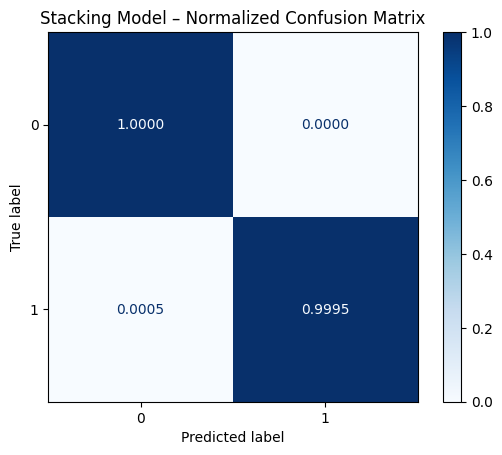

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_meta_pred,
    normalize="true",
    cmap="Blues",
    values_format=".4f"
)
plt.title("Stacking Model – Normalized Confusion Matrix")
plt.show()


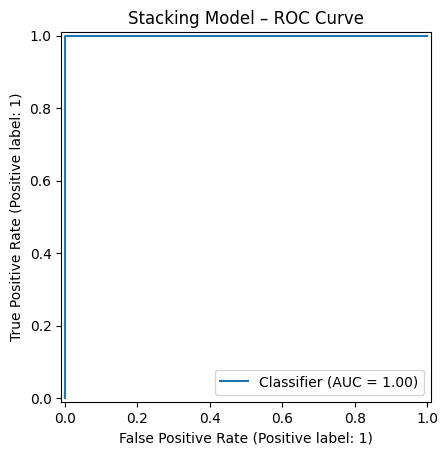

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test,
    y_meta_prob
)
plt.title("Stacking Model – ROC Curve")
plt.show()


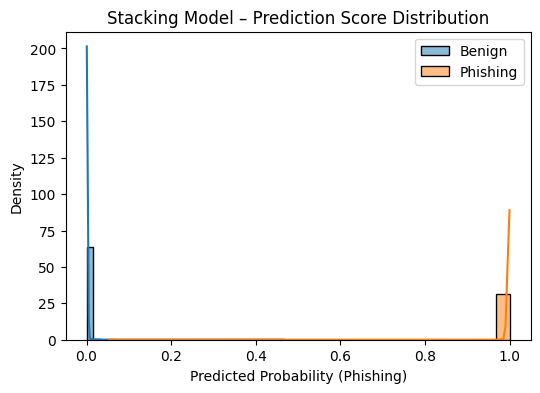

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(y_meta_prob[y_test==0], bins=30, label="Benign", stat="density", kde=True)
sns.histplot(y_meta_prob[y_test==1], bins=30, label="Phishing", stat="density", kde=True)
plt.legend()
plt.title("Stacking Model – Prediction Score Distribution")
plt.xlabel("Predicted Probability (Phishing)")
plt.show()


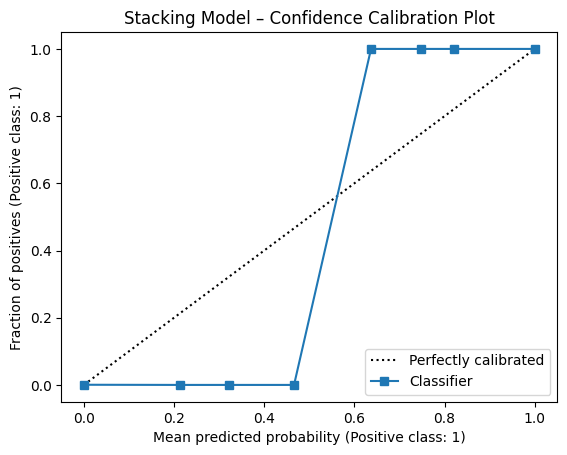

In [ ]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

CalibrationDisplay.from_predictions(
    y_test,
    y_meta_prob,
    n_bins=10,
    strategy="uniform"
)

plt.title("Stacking Model – Confidence Calibration Plot")
plt.show()


# Cross validation

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# -------------------------------
# 1️⃣ Charger les modèles déjà entraînés
# -------------------------------
url_model = joblib.load(url_model_path)
content_model = joblib.load(content_model_path)
html_model = joblib.load(html_model_path)

print("✅ Modèle URL/DNS chargé")
print("✅ Modèle Content/HAR chargé")
print("✅ Modèle HTML chargé")

# -------------------------------
# 2️⃣ Générer les OOF predictions pour l'entraînement du meta-model
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# OOF predictions pour chaque modèle
oof_url = cross_val_predict(
    url_model, X_url_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

oof_content = cross_val_predict(
    content_model, X_content_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

oof_html = cross_val_predict(
    html_model, X_html_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

# Combiner les probabilités en features pour le meta-model
X_meta_train = np.column_stack([oof_url, oof_content, oof_html])
y_meta_train = y_train

# -------------------------------
# 3️⃣ Entraîner le meta-model
# -------------------------------
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

print("✅ Meta-model entraîné")

# -------------------------------
# 4️⃣ Générer les features meta pour le test set
# -------------------------------
url_test_proba = url_model.predict_proba(X_url_test)[:, 1]
content_test_proba = content_model.predict_proba(X_content_test)[:, 1]
html_test_proba = html_model.predict_proba(X_html_test)[:, 1]

X_meta_test = np.column_stack([url_test_proba, content_test_proba, html_test_proba])

# -------------------------------
# 5️⃣ Prédictions finales du stacking
# -------------------------------
y_pred_stack = meta_model.predict(X_meta_test)
y_pred_stack_proba = meta_model.predict_proba(X_meta_test)[:, 1]

# -------------------------------
# 6️⃣ Évaluation
# -------------------------------
print("=== Stacking Model ===")
print(classification_report(y_test, y_pred_stack,digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_stack_proba))


✅ Modèle URL/DNS chargé
✅ Modèle Content/HAR chargé
✅ Modèle HTML chargé
✅ Meta-model entraîné
=== Stacking Model ===
              precision    recall  f1-score   support

           0     0.9988    0.9992    0.9990      4000
           1     0.9992    0.9988    0.9990      4000

    accuracy                         0.9990      8000
   macro avg     0.9990    0.9990    0.9990      8000
weighted avg     0.9990    0.9990    0.9990      8000

ROC-AUC: 0.999998375


# Data leakage verification

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Shuffle labels
y_shuffled = y_train.sample(frac=1, random_state=42).values

meta_model_leak_test = LogisticRegression()
meta_model_leak_test.fit(X_meta_train, y_shuffled)

y_pred = meta_model_leak_test.predict_proba(X_meta_test)[:, 1]

print("AUC with shuffled labels:", roc_auc_score(y_test, y_pred))



AUC with shuffled labels: 0.07280949999999997


accuracy droped after testing with shuffled labels which means there is a small probability of having a leakage

In [ ]:
from sklearn.metrics import roc_auc_score

y_train_pred = meta_model.predict_proba(X_meta_train)[:, 1]
print("Train AUC:", roc_auc_score(y_train, y_train_pred))
# the accacy on traing dataset is not equal to 1.0 (not perfect)

Train AUC: 0.9999997890625


In [ ]:
rng = np.random.RandomState(42)
X_noise = rng.rand(*X_meta_train.shape)

meta_noise = LogisticRegression()
meta_noise.fit(X_noise, y_train)

y_noise_pred = meta_noise.predict_proba(
    rng.rand(*X_meta_test.shape)
)[:, 1]

print("AUC random noise:", roc_auc_score(y_test, y_noise_pred))


AUC random noise: 0.4891419374999999


In [ ]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(
    y_train,
    meta_model.predict(X_meta_train)
)

test_acc = accuracy_score(
    y_test,
    meta_model.predict(X_meta_test)
)

print("Train acc:", train_acc)
print("Test acc:", test_acc)


Train acc: 0.99959375
Test acc: 0.99975


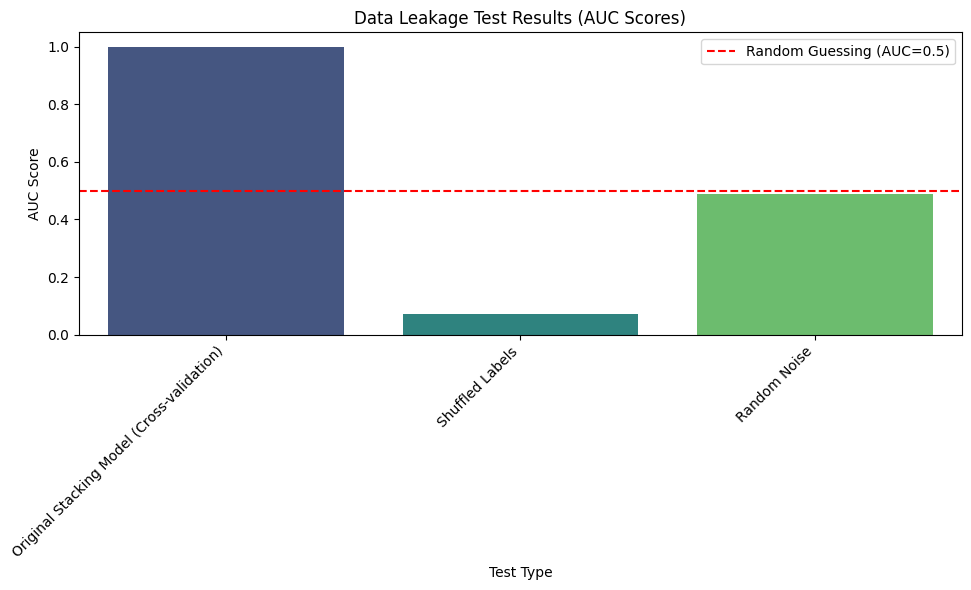

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the executed cells
auc_scores = {
    'Original Stacking Model (Cross-validation)': 0.999998375,
    'Shuffled Labels': 0.07280949999999997,
    'Random Noise': 0.4891419374999999
}

auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Test Type', 'AUC Score'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Test Type', y='AUC Score', data=auc_df, palette='viridis', hue='Test Type', legend=False) # Add hue and legend=False
plt.title('Data Leakage Test Results (AUC Scores)')
plt.ylabel('AUC Score')
plt.xlabel('Test Type')
plt.ylim(0, 1.05) # Set y-axis limit from 0 to slightly above 1 for better visualization
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guessing (AUC=0.5)') # Add a line for random guessing
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Conclusion:
The tests we conducted indicate that there is no data leakage in training or testing the stacking model. The high accuracy is probably due to the fact that the three base models are already very strong and complementary, providing highly informative predictions for the meta-classifier. Additionally, the dataset features patterns that make phishing and benign samples relatively easy to separate. Overall, the stacking approach successfully combines the strengths of the individual models while maintaining a leakage-free evaluation.